# Experiment 2
Code Overview :

+ select three features manually. description - title - price
+ tf-idf to get embedding of non numeric features
+ manual feature selection for dimention reduction
+ add class weight in logistic regression to solve imbalanced data distribution problem


In [1]:
!pip install hazm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394489 sha256=be554d7cabecd8dd95c2aa0f9ee253f1862b0e03022d508b94ea2e7d9696bc3a
  Stored in directory: /root/.cache/pip/wheels/ac/62/f6/88933dadcd64a1614894614aa68cf57c4b8e5256acb650b1f1
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp39-cp39-linux_x86_64.whl size=180376 sha256=e7d7beb6f55ee01ee6e8af770053d831808d0c989941b05a10afce2f6ca687a2
  Stored in directory: /root/.cache/pip/wheels/8e/ff/82/9326b96f96f47472e02c453697b225813e4650c0ed4df2cd49
Successfully built nltk libwapiti
  Attempting unin

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from hazm import Normalizer, sent_tokenize,word_tokenize,Lemmatizer,Stemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import datasets
import pandas as pd 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import codecs
import torch

In [4]:
divar_df = pd.read_csv('divar_sample_10k.csv')

In [5]:
input_x = divar_df[np.setdiff1d(divar_df.columns, ['cat1'])]
output_y = divar_df['cat1']

### Preprocessing non numeric data

removing stopwords

In [8]:
normalizer = Normalizer()
stopwords = [normalizer.normalize(x.strip()) for x in codecs.open(
    'stopwords.txt', 'r', 'utf-8').readlines()]
stopwords.extend(['تماس', 'تلگرام', 'واتساپ', 'با سلام', 'سلام', 'فروش', 'فوری',
                 'قیمت', 'مقطوع', 'تخفیف', 'نو', 'در حد نو', 'خرید', 'اقساطی', 'تحویل', 'اقساط'])

In [9]:
for idx , sent in enumerate(input_x['desc']):
    sent = sent.replace('$NUM' , ' ')
    input_x['desc'][idx] = '  '.join([str(elem) for elem in [t for t in word_tokenize(sent) if t not in stopwords]])
    if idx % 1000 == 0:
      print(idx)

<ipython-input-9-df67a86b757f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_x['desc'][idx] = '  '.join([str(elem) for elem in [t for t in word_tokenize(sent) if t not in stopwords]])


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [10]:
for idx , sent in enumerate(input_x['title']):
    sent = normalizer.normalize(sent)
    input_x['title'][idx] = '  '.join([str(elem) for elem in [t for t in word_tokenize(sent) if t not in stopwords]])
    if idx % 1000 == 0:
      print(idx)

<ipython-input-10-3e008e98ddc5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_x['title'][idx] = '  '.join([str(elem) for elem in [t for t in word_tokenize(sent) if t not in stopwords]])


0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [11]:
normalizer = Normalizer()
scalar = StandardScaler()
numeric_scaled_features = pd.DataFrame(scalar.fit_transform(input_x[['price']]) , columns=['price'])

## Tf-idf


In [12]:
tfidf_generator = TfidfVectorizer(ngram_range=(1, 1), norm='l2', use_idf=True, preprocessor=normalizer.normalize, tokenizer=word_tokenize)
desc_tfidt_matrix = tfidf_generator.fit_transform(input_x['desc'])

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [13]:
tfidf_generator = TfidfVectorizer(ngram_range=(1, 1), norm='l2', use_idf=True, preprocessor=normalizer.normalize, tokenizer=word_tokenize)
title_tfidt_matrix = tfidf_generator.fit_transform(input_x['title'])

## select 100 feature that has most sum tf-idf value. 

In [14]:
desc_df = pd.DataFrame(desc_tfidt_matrix.toarray())
sums_words_tfidf = []
for col in desc_df.columns:
    sums_words_tfidf.append((col, desc_df[col].sum()))
sorted_tfidf_desc = sorted(sums_words_tfidf, key=lambda x: x[1])[-100:]
selected_tfidf_desc = desc_df[[col[0] for col in sorted_tfidf_desc]]

selected_tfidf_desc.columns = [str(i) for i in range(0,100)]

In [15]:
title_df = pd.DataFrame(title_tfidt_matrix.toarray())
sums_words_tfidf = []
for col in title_df.columns:
    sums_words_tfidf.append((col, title_df[col].sum()))
sorted_tfidf_title = sorted(sums_words_tfidf, key=lambda x: x[1])[-100:]
selected_tfidf_titles = title_df[[col[0] for col in sorted_tfidf_title]]

selected_tfidf_titles.columns = [str(i) for i in range(100,200)]

In [16]:
input_x = pd.concat([selected_tfidf_desc , selected_tfidf_titles , numeric_scaled_features], axis=1) 

In [17]:
all_data_df = pd.concat([input_x ,output_y], axis=1) 
all_data_df.to_csv('tfidf_manual_dim_reduction_df.csv')

### Model Selection and train it
Logistic Regression

In [18]:
input_x.columns = input_x.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(input_x, output_y, test_size=0.25, random_state=16)

In [38]:
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [39]:
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(6), range(6))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(6,6))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)

The f1 score for the testing data: 0.6087204742099432


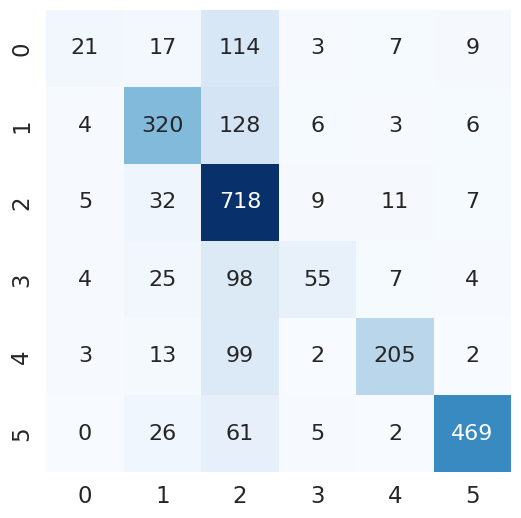

In [40]:
#Calculating and printing the f1 score 
f1_test = f1_score(y_test, y_pred , average='macro')
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_test, y_pred)

In [41]:
accuracy_score(y_test, y_pred)

0.7152

  ## add class weight in logistic regression to solve imbalanced data distribution problem

In [42]:
logreg = LogisticRegression(random_state=16 , class_weight='balanced')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The f1 score for the testing data: 0.61623224344191


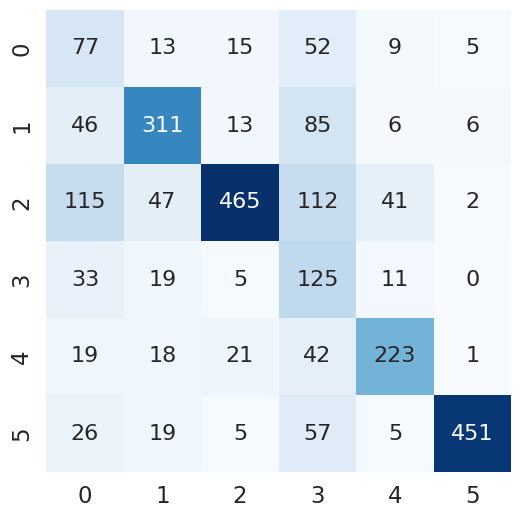

In [43]:
#Calculating and printing the f1 score 
f1_test = f1_score(y_test, y_pred , average='macro')
print('The f1 score for the testing data:', f1_test)

#Ploting the confusion matrix
conf_matrix(y_test, y_pred)